# This notebook creates the plots used on the poster

In [5]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid.axislines import Subplot
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
import model_class; reload(model_class)
model = model_class.model() 
n_populations = model.n_populations

%matplotlib inline

save_fig = style.save_fig
figure_path = style.figure_path

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
colors = style.colors

label_populations = hf.rlbl(model.populations)

## solve_model: requirement for all mean field predictions

In [3]:
def solve_model(model,
               v_guess_0=np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6]),
               jacobian=False, root_method='hybr', options=None):
    """Solve for model, given the initial guess v_guess_0.
    Returns solution = v0.
    """
    from scipy.optimize import root

    if jacobian==False:
        jac = False
    else:
        print("Use jacobian")
        jac = model.jacobian
        
    # Run on initial guess v_guess_0
    sol = root(model.root_v0, v_guess_0, jac=jac, method=root_method, options=options)
    if sol["success"]:
        v0  = sol["x"]
        if np.all(v0 < 1./model.t_ref): 
            return v0
        else:       # converged unphysically (v0 >= 1/t_ref)
            raise Exception("Converged unphysically for v_guess_0")
    else:   
        raise Exception("No solution found for v_guess_0")

## Population size

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


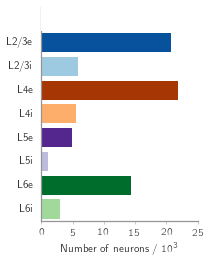

In [3]:
######################################################
# Population size
######################################################
model = model_class.model()   

fig2 = plt.figure()
fig2.set_size_inches(style.figsize[0]*0.50, style.figsize[1]) 
ax3 = hf.add_subplot(fig2, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

bar_edges = np.arange(0, 8, 1) + 0.1
if reverse_order:
    bar_edges = bar_edges[::-1]
ticks=np.arange(0.5, 8., 1)

for i in range(8):
    ax3.barh(bar_edges[i], model.n_neurons[i] * 1e-3, height=0.8, color=colors[i], linewidth=0)
ax3.set_yticks(ticks)
yticklabels = label_populations
if reverse_order:
    yticklabels = yticklabels[::-1]
ax3.set_yticklabels(yticklabels)
ax3.set_xlabel('Number of neurons / $10^3$') 
style.fixticks(ax3)
ax3.yaxis.set_ticks_position('none') 
ax3.set_ylim(0, 9)

ax3.axhspan(8, 9, -4, 1, facecolor='white', linewidth=0, zorder=20, alpha=1)

    
fig_name    = "population_size"
if save_fig:
    hf.saving_fig(fig2, figure_path, fig_name, verbose=False) 

## Synapse numbers

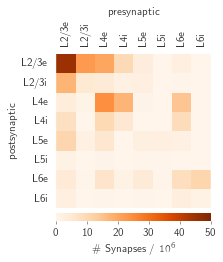

In [4]:
model = model_class.model()   

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

def plot_heatmap(ax, data, model, cbar_label, cbar_format, clim, cbar_ticks, cmap=cm.Oranges):   
    extent = [0, 8, 0, 8]
    heatmap = ax.imshow(data, interpolation='none', extent=extent, cmap=cmap)
    
    # Color bar (with tight layout)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", "5%", pad="3%")
    cbar = plt.colorbar(heatmap, cax=cax, 
                        format=cbar_format, 
                        label=cbar_label, 
                        orientation='horizontal')

    cbar.set_ticks(cbar_ticks)
    cbar.outline.set_linewidth(0.2)
    #cbar.set_clim(*clim)
    heatmap.set_clim(*clim)
    
    # Set ticks: left and top
    ticks=np.arange(0.5, 8., 1)
    # xticks
    ax.set_xlabel('presynaptic')
    ax.xaxis.set_tick_params(labeltop='on')
    ax.xaxis.set_tick_params(labelbottom='off')
    ax.xaxis.set_label_position("top")
    ax.set_xticks(ticks)
    ax.set_xticklabels(label_populations, rotation=90)
    # yticks
    ax.yaxis.set_tick_params(labelbottom='off')
    
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.01)
        ax.spines[axis].set_color('0.9')
    cbar.outline.set_linewidth(0.01)

    ax.grid(False)      # Turn of grid (distracts!)
    
    
# Figure
fig = plt.figure()
fig.set_size_inches(style.figsize[1], style.figsize[1]) 
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)

######################################################
# Total synapse numbers
######################################################
data = model.C_ab * 1e-6
cbar_label  = "\# Synapses / $10^{6}$"
cbar_format = "%i"
clim        = (0, 50)
cbar_ticks  = np.arange(0, 60, 10)
plot_heatmap(ax1, data, model, cbar_label, cbar_format, clim, cbar_ticks)   
    
# y ticks
ticks=np.arange(0.5, 8., 1)
label_populations = hf.rlbl(model.populations)
ax1.yaxis.set_tick_params(labelbottom='on')
ax1.set_ylabel('postsynaptic')
ax1.set_yticks(ticks)
ax1.set_yticklabels(label_populations[::-1])

fig_name    = "synapse_numbers"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False)   

## Network activity

In [5]:
def plot_raster(ax, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    with h5py.File(path_res_file, "r") as res_raster:
        ymax_raster = res_raster.attrs["ymax_raster"]
        yticks = res_raster.attrs["yticks"]

        for i, population in enumerate(populations):
            res_raster_pop = res_raster[str(population)]
            for times, neuron_ids in res_raster_pop.values():
                ax.plot(times * 1e3 - 100, neuron_ids, ',', ms=2, color=colors[i])              

    # Raster Plot
    yticks[2] = yticks[2] * 0.95
    yticks[3] = yticks[3] * 1.05
    
    xlim = (t_trans * 1e3 - 100, t_sim * 1e3 - 100) 
    ylim = (0, ymax_raster)
    xticks = np.linspace(0, 400, 5)
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Simulation time / ms')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

In [6]:
def box_plot(ax, data, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    """Data has to be in the right order (will not be reversed)"""
    
    boxprops = dict(linewidth=0.5, color=style.text_color)
    flierprops  = dict(marker='+', markersize=style.cross_size*0.5,
                      linestyle='None', mew=0.5)
    medianprops = dict(color=style.text_color, linewidth=0.5)
    meanprops  = dict(marker='*', markersize=4, 
                      mec='0.95', #style.text_color, 
                      markerfacecolor='0.95', #style.text_color,
                      linestyle='None', mew=0.5)

    
    box = ax.boxplot(data,
                     vert=False, showfliers=True, showmeans=True,
                     boxprops=boxprops,
                     flierprops=flierprops, medianprops=medianprops,
                     meanprops=meanprops,
                     patch_artist=True)

    if reverse_order:
        box_colors = colors[::-1]
    else:
        box_colors = colors[:]        

    for i, population in enumerate(populations):
        box["boxes"][i].set_alpha(0.8)
        box["boxes"][i].set_facecolor(box_colors[i])
        #box["boxes"][i].set_color(box_colors[i])
        box["fliers"][i].set_color(box_colors[i])
        box["whiskers"][2*i].set_color(box_colors[i])
        box["whiskers"][2*i+1].set_color(box_colors[i])
        box["caps"][2*i].set_color(box_colors[i])
        box["caps"][2*i+1].set_color(box_colors[i])

    yticks = np.arange(n_types * 0.75, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations + 1.0)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)   

In [7]:
def plot_single_rates(ax, path_res_file, n_spikes_recorded=1000, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    single_rates = np.empty((n_populations, n_spikes_recorded))
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0/single_rates"]
        for i, population in enumerate(populations):
            if reverse_order:
                single_rates[-(i + 1)] = res_grp[population][:]
            else:
                single_rates[i] = res_grp[population][:]

    box_plot(ax, single_rates.T, path_res_file, reverse_order)
    
    ax.set_xlabel("Single neuron firing rates / Hz")

save figure to network_activity


/usr/local/lib/python3.4/dist-packages/matplotlib/patches.py:102: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


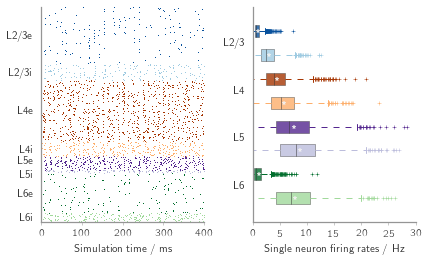

In [8]:
fig = plt.figure()
fig.set_size_inches(style.figsize[0], style.figsize[1]) 
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

# Raster plot
data_path = "/export/data-schuessler/data_microcircuit/micro"
raster_sim_spec = "raster_plot"
res_file_name = raster_sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)
plot_raster(ax1, path_res_file)

# Single neuron rates
data_path = "/export/data-schuessler/data_microcircuit/micro"
sim_spec = "spon_act_statistic"
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)
plot_single_rates(ax2, path_res_file, n_spikes_recorded=1000)
  
fig_name = "network_activity"
for ax in fig.axes:
    style.fixticks(ax)   
    ax.yaxis.set_ticks_position('none') 
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name)  

## Mean field vs. simulation

In [9]:
def CV_ISI_mf(v0, model=model_class.model()):
    """Coefficient of variation of interspike interval as predicted by Brunel
    """
    from scipy.integrate import dblquad
    from scipy.special import erf, erfcx
    mu     = model.mu(v0)
    sd     = model.sd(v0)
    lows   = (model.V_r - mu) / sd
    ups    = (model.theta - mu) / sd
    bounds = np.array([lows, ups]).T

    # Double integral
    def func(u, x):
        return np.exp(x**2) * np.exp(-u**2) * erfcx(-u)**2
    gfun = lambda x: -np.inf
    hfun = lambda x: x
    dbl_integral  = np.array([dblquad(func, low, up, gfun, hfun, epsabs=1.49e-08, epsrel=1.49e-08)[0]
                                   for low, up in bounds])

    cv_theo = np.sqrt(2 * np.pi * v0**2 * dbl_integral * model.tau_m**2) # Define as sd / mean, NOT var / mean**2
    return cv_theo

In [10]:
def prob_V(V_array, mu_i, sd_i, v0_i, model=model_class.model()):
    """Membrane potential probability distribution P(V_m) according to Brunel"""
    from scipy.integrate import quad
    step        = lambda x: 0.5 * (np.sign(x) + 1)  # Heaviside step function
    red         = lambda V: (V - mu_i) / sd_i           # reduced voltage
    P_integrand = lambda u: step(u - red(model.V_r)) * np.exp(u**2) # integrand
    
    Vs = V_array - model.E_L # shift since Brunel's model is using E_L = 0
    
    # Integral boundaries
    lowers  = red(Vs)
    upper  = red(model.theta)
  
    integrals   = np.array([quad(P_integrand, lower, upper)[0] for lower in lowers])

    P_V_array   = 2 * v0_i * model.tau_m / sd_i * np.exp(- (Vs - mu_i)**2 / sd_i**2) * integrals
    
    return step(-Vs + model.theta) * P_V_array

In [11]:
######################################################
# Mean field results
######################################################

# Model
neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
model     = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd) 

v_guess_0       = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
jacobian=True
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

t_int0      = time.time()
rate_mf     = solve_model(model, v_guess_0,
                          jacobian=jacobian,
                          root_method=root_method, options=options)
t_int1      = time.time() - t_int0
print("Integration time: %.2f"%(t_int1))

t_int0      = time.time()
cv_isi_mf   = CV_ISI_mf(rate_mf, model=model)
t_int1      = time.time() - t_int0
print("CV calc time: %.2f"%(t_int1))


######################################################
# Simulation results
#####################################################

######################################################
# RATES and IRREGULARITY
######################################################
sim_spec = "spon_act_statistic"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    n_sims = len(res_file.keys())

    rates_mean_all  = np.zeros((n_sims, n_populations))
    cv_isi_mean_all = np.zeros((n_sims, n_populations))
    synchrony_all   = np.zeros((n_sims, n_populations))
    for j, sim_spec2 in enumerate(res_file.keys()):  
        res_grp = res_file[sim_spec2]

        rates_mean_all[j]   = res_grp["rates_mean"][:]
        cv_isi_mean_all[j]  = res_grp["cv_isi_mean"][:]
        synchrony_all[j]    = res_grp["synchrony"][:]
        
######################################################
# MEMBRANE POTENTIALS
######################################################
sim_spec = "membrane_potential"
data_path = "/export/data-schuessler/data_microcircuit/micro" 
res_file_name = sim_spec + "_res.hdf5"
path_res_file = os.path.join(data_path, res_file_name)

(area, t_sim, t_trans, t_measure, dt, 
    populations, layers, types, 
    n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

# Get voltage data
with h5py.File(path_res_file, "r") as res_file:
    sim_spec2 = "0"
    res_grp = res_file[sim_spec2]
    # Rates
    rates_mean   = res_grp["rates_mean"][:]
    rates_std    = res_grp["rates_std"][:]
    # Voltage
    dset_times_volt     = res_grp["times_volt"]
    t_min_volt = dset_times_volt.attrs["t_min_volt"]
    t_max_volt = dset_times_volt.attrs["t_max_volt"]
    dt_volt    = dset_times_volt.attrs["dt_volt"]
    volt_histo_means  = res_grp["volt_histo_means"][:]
    V_min       = res_grp.attrs["V_min"]
    V_max       = res_grp.attrs["V_max"]
    n_bins_volt = res_grp.attrs["n_bins_volt"]
    n_neurons_rec_voltage = res_grp.attrs["n_neurons_rec_voltage"][:]
    
# Voltage: Index of V = E_L
V_step = (V_max - V_min) / n_bins_volt
V_array = np.arange(V_min, V_max, V_step)
V_r_arg = np.argmin(np.abs(V_array - (model.V_r + model.E_L))) # Index of neurons in refractory period
n_t = (t_max_volt - t_min_volt) / dt_volt # number of time bins
    
P_V_theo      = np.zeros((n_populations, V_array.shape[0]))
P_V_data_plot = np.zeros(volt_histo_means.shape)
for i, population in enumerate(populations):
    # Remove neurons in refractory period
    with h5py.File(path_res_file, "r") as res_file:
        single_rates = res_file["0/single_rates/" + population][:n_neurons_rec_voltage[i]]
    P_V_data =  volt_histo_means[i].copy()
    P_V_data[V_r_arg] -= np.sum(single_rates) * model.t_ref * n_t
    # Normalization
    norm_factor = n_t * n_neurons_rec_voltage[i] * V_step
    P_V_data_normed = P_V_data / norm_factor
    # Adjust histogram for "steps"
    P_V_data_plot[i] = hf.adjust_steps(P_V_data_normed)  
    
    # Theoretical distirbution using Brunel's mu and sd but measured rate v0
    P_V_theo[i] = prob_V(V_array, model.mu(rate_mf)[i], model.sd(rate_mf)[i], rate_mf[i], model=model)

Use jacobian
Integration time: 0.06
CV calc time: 0.60


In [43]:
def plot_compare_sim_mf(data_sim, data_mf, ax):
    y_mf = np.arange(n_populations) + 0.1
    yticks = np.arange(n_populations) + 0.5
    if reverse_order:
        y_mf = y_mf[::-1]
        yticks = yticks[::-1]
    bar_height = 0.8 

    for i, population in enumerate(populations):
        ax.plot(data_sim[:, i], [yticks[i]]*rates_mean_all.shape[0], '+', color=colors[i], mew=0.5, ms=style.cross_size)
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                color=colors[i], linewidth=0, fill=True, alpha=0.4) 
        ax.barh(y_mf[i], data_mf[i], height=bar_height, 
                edgecolor=colors[i], linewidth=0.8, fill=False, alpha=1.0) 
    ax.barh([0], [0], color="lightgray", edgecolor="darkgray", linewidth=0.8, fill=True, alpha=1.0, label="mean field") 
    ax.plot([-1], [0], "+", color="gray", alpha=0.8, label="simulated", mew=1., ms=style.cross_size / style.legend_ms) 

    yticklabels = hf.rlbl(populations)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

In [45]:
def plot_membrane_potential(V_array, P_V_data_plot, P_V_theo, ax1):
    V_range_plot = (-85, -48)
    ymax = 0.13 # max height for each population
    for i, population in enumerate(populations):
        if reverse_order:
            offset = (n_populations - (i + 1)) * ymax
        else:
            offset = i * ymax
        ax1.plot(V_array, P_V_data_plot[i] + offset, 
                 "-", color=colors[i], drawstyle="steps")
        ax1.plot(V_array, P_V_theo[i] + offset, 
                 "-", color=colors[i])
        ax1.plot(V_range_plot, [offset]*2, "-", color=style.axes_color, linewidth=0.5) # line indicating P = 0

    # Labels: Resting potential and treshhold
    ax1.plot([model.E_L + model.theta]*2, [0, n_populations * ymax], 
             "--", linewidth=0.7, color="darkgray", zorder=0, label="$\\theta$")
    ax1.plot([model.E_L]*2, [0, n_populations * ymax], 
             "-.", linewidth=0.7, color="darkgray", zorder=0, label="$E_L$")
    
    # Axes label, etc.
    ax1.set_xlabel('Membrane potential $V_m$ / mV')
    ax1.set_ylabel('Probability $P(V)$')
    ax1.set_ylim(0, n_populations * ymax)
    ax1.set_xlim(*V_range_plot)
    ax1.yaxis.set_label_position("right")
    ax1.set_xticks(np.arange(-80, -50+1, 10))

    # Create ticks manually
    n_ticks = 2 
    ytickmax = ymax - 0.02
    yto           = [0.00, 0.05]#np.arange(0, ytickmax, ytickmax/n_ticks)#
    yto_str = ["%.2f"%ytoi for ytoi in yto]
    yt_offset     = np.repeat(np.arange(0,  n_populations * ymax, ymax), n_ticks)
    y_ticks = np.tile(yto, n_populations) + yt_offset
    y_ticklabels = np.tile(yto_str, n_populations)
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_ticklabels)  
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Fixticks
    ax1.grid(False)
    for t in ax1.xaxis.get_ticklines(): t.set_color(style.axes_color)
    for t in ax1.yaxis.get_ticklines(): t.set_color(style.axes_color)
    ax1.yaxis.set_ticks_position("right")
    ax1.xaxis.set_ticks_position("bottom")

save figure to results


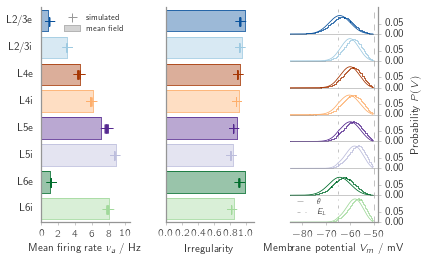

In [46]:
######################################################
# Plotting
######################################################

fig1 = plt.figure()
fig1.set_size_inches(style.figsize[0], style.figsize[1]) 
ax1 = hf.add_subplot(fig1, n_rows_cols=(1, 3), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig1, n_rows_cols=(1, 3), index_row_col=(0, 1), rowspan=1, colspan=1)
ax3 = hf.add_subplot(fig1, n_rows_cols=(1, 3), index_row_col=(0, 2), rowspan=1, colspan=1)

plot_compare_sim_mf(rates_mean_all, rate_mf, ax1)
ax1.set_xlabel("Mean firing rate $\\nu_a$ / Hz")
ax1.set_xlim(0, 10.5)
ax1.legend(loc="best", fontsize=8)
    
plot_compare_sim_mf(cv_isi_mean_all, cv_isi_mf, ax2)
ax2.set_xlabel("Irregularity")
ax2.set_xlim(0, 1.1)
ax2.set_yticks([])

plot_membrane_potential(V_array, P_V_data_plot, P_V_theo, ax3)
ax3.legend(loc=(0.01, 0.01), fontsize=8, numpoints=3)
    
fig_name = "results"
for ax in (ax1, ax2):
    style.fixticks(ax) 
    ax.yaxis.set_ticks_position('none') 
if save_fig:
    hf.saving_fig(fig1, figure_path, fig_name)  

## Applying mean field theory

In [15]:
g_nom       = 4     # working point
g_low       = 3     # lower boundary
g_up        = 10    # upper boundary
g_step      = 0.1   # step size

n_low       = int((g_nom - g_low) / g_step) + 1
n_up        = int((g_up - g_nom) / g_step) + 1
n           = n_low + n_up - 1 # g=4 only once
gs_low      = np.linspace(g_nom, g_low, n_low, -1)
gs_up       = np.linspace(g_nom, g_up, n_up)
gs_order    = np.concatenate((gs_low, gs_up), axis=0)
gs          = np.concatenate((gs_low[::-1], gs_up[1:]), axis=0)
rates       = np.zeros((n, n_populations))
cv_isis     = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
rate_ext        = 8
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for g in gs_order:
    if g == g_nom:
        v_guess_0 = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
    
    model_new   = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd, 
                                    g=g, 
                                    rate_ext=rate_ext)
    
    i = np.where(g==gs)[0][0]   # get the correct index
    v0          = solve_model(model_new, v_guess_0,
                              root_method=root_method, options=options)

    v_guess_0 = v0      # next intial guess
    rates[i] = v0

In [16]:
# Changing the external rate

r_nom       = 8     # working point
r_low       = 4   # lower boundary
r_up        = 12   # upper boundary
r_step      = 0.1  # step size

n_low       = int((r_nom - r_low) / r_step) + 1
n_up        = int((r_up - r_nom) / r_step) + 1
n           = n_low + n_up - 1 # r=8 only once
rs_low      = np.linspace(r_nom, r_low, n_low, -1)
rs_up       = np.linspace(r_nom, r_up, n_up)
rs_order    = np.concatenate((rs_low, rs_up), axis=0)
rs          = np.concatenate((rs_low[::-1], rs_up[1:]), axis=0)
rates_r       = np.zeros((n, n_populations))
cv_isis_r     = np.zeros((n, n_populations))

neuron_model    = "iaf_psc_exp"
connection_rule = "fixed_indegree"
weight_rel_sd   = 0.1
g               = 4
root_method='hybr'
options= {"xtol": 1e-13, "maxfev": 10**3}

for rate_ext in rs_order:
    if rate_ext == r_nom:
        v_guess_0 = np.array([ 0.6,  2.5,  4. ,  5.6,  8.2,  8. ,  1.6,  7.6])
    
    model_new   = model_class.model(neuron_model=neuron_model,
                                    connection_rule=connection_rule, 
                                    weight_rel_sd=weight_rel_sd, 
                                    g=g, 
                                    rate_ext=rate_ext)
    
    i = np.where(rate_ext==rs)[0][0]   # get the correct index
    v0          = solve_model(model_new, v_guess_0,
                              root_method=root_method, options=options)

    v_guess_0 = v0      # next intial guess
    rates_r[i] = v0

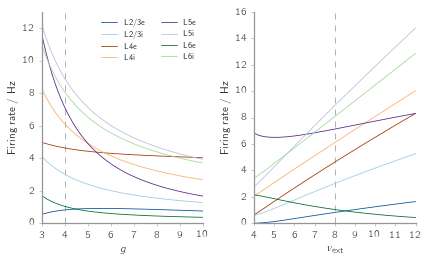

In [17]:
# Plotting
fig = plt.figure()
fig.set_size_inches(style.figsize[0], style.figsize[1]) 
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax2 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)

for i, population in enumerate(model.populations):
    ax1.plot(gs, rates[:, i], linestyle='-', color=colors[i],
        label=hf.rlbl(population))
    ax2.plot(rs, rates_r[:, i], linestyle='-', color=colors[i],
        label=hf.rlbl(population))
    
ax1.set_ylabel("Firing rate / Hz")
ax1.set_ylim(0, 13)
ax1.set_xlabel("$g$")
ax1.plot([g_nom]*2, ax1.get_ylim(), 
     "--", linewidth=1., color="darkgray", alpha=0.9, zorder=0)
    
ax2.set_ylabel("Firing rate / Hz")
ax2.set_ylim(0,)
ax2.set_xlabel(r"$\nu_\mathrm{ext}$")
ax2.plot([r_nom]*2, ax2.get_ylim(), 
     "--", linewidth=1., color="darkgray", alpha=0.9, zorder=0)

ax1.legend(loc="best", ncol=2, fontsize=8)

for ax in fig.axes:
    style.fixticks(ax)
    # Plot working point


fig_name = "change_parameters"
if save_fig:
    hf.saving_fig(fig, figure_path, fig_name, verbose=False) 